# Convolutional Neural Network (CNN) for the EMNIST dataset

-----
### EMNIST dataset: https://www.nist.gov/itl/iad/image-group/emnist-dataset
### Direct download: http://www.itl.nist.gov/iaui/vip/cs_links/EMNIST/gzip.zip
-----
#### A very well-written introduction to Convolutional Neural Networks: [Part 1](https://adeshpande3.github.io/adeshpande3.github.io/A-Beginner's-Guide-To-Understanding-Convolutional-Neural-Networks/) [Part 2](https://adeshpande3.github.io/adeshpande3.github.io/A-Beginner's-Guide-To-Understanding-Convolutional-Neural-Networks-Part-2/) [Part 3](https://adeshpande3.github.io/adeshpande3.github.io/The-9-Deep-Learning-Papers-You-Need-To-Know-About.html)

### Import necessary modules:

In [1]:
import os
#os.environ['CUDA_VISIBLE_DEVICES'] = '' # hides the GPU from tensorflow (for science)

import gzip
import keras
import matplotlib.pyplot as plt
import numpy as np
import random
import struct
import time

Using TensorFlow backend.


### List computing devices available to tensorflow:

In [2]:
from tensorflow.python.client import device_lib
device_list = device_lib.list_local_devices()
[x.name for x in device_list]

['/device:CPU:0', '/device:GPU:0']

### Set up global configuration for the notebook:

In [3]:
%matplotlib inline
random.seed(12345)

image_dir = '/home/jaeger/dev/python/emnist/gzip'
labels = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz'
categories = len(labels)

batch_size = 1024
epochs = 50

model_path = '/home/jaeger/dev/python/emnist/emnist_cnn_model.h5'

### Define helper functions and read the dataset from disk:

In [4]:
def read_idx(filename):
    # the idx file format can be found at the bottom of http://yann.lecun.com/exdb/mnist/
    print('Processing data from %s.' % filename)
    with gzip.open(filename, 'rb') as f:
        # read the "magic number" first
        z, dtype, dim = struct.unpack('>HBB', f.read(4))
        print('Dimensions:', dim)
        # get the shape (size in each dimension) of the data
        shape = tuple(struct.unpack('>I', f.read(4))[0] for d in range(dim))
        print('Shape:', shape)
        # return the data as a reshaped numpy array
        return np.frombuffer(f.read(), dtype=np.uint8).reshape(shape)

def load_emnist():
    # the dataset can be found here: http://www.itl.nist.gov/iaui/vip/cs_links/EMNIST/gzip.zip
    train_images = os.path.join(image_dir, 'emnist-byclass-train-images-idx3-ubyte.gz')
    train_labels = os.path.join(image_dir, 'emnist-byclass-train-labels-idx1-ubyte.gz')
    test_images = os.path.join(image_dir, 'emnist-byclass-test-images-idx3-ubyte.gz')
    test_labels = os.path.join(image_dir, 'emnist-byclass-test-labels-idx1-ubyte.gz')

    train_X = read_idx(train_images)
    train_y = read_idx(train_labels)
    test_X = read_idx(test_images)
    test_y = read_idx(test_labels)
    
    return (train_X, train_y, test_X, test_y)

raw_train_X, raw_train_y, raw_test_X, raw_test_y = load_emnist()

Processing data from /home/jaeger/dev/python/emnist/gzip/emnist-byclass-train-images-idx3-ubyte.gz.
Dimensions: 3
Shape: (697932, 28, 28)
Processing data from /home/jaeger/dev/python/emnist/gzip/emnist-byclass-train-labels-idx1-ubyte.gz.
Dimensions: 1
Shape: (697932,)
Processing data from /home/jaeger/dev/python/emnist/gzip/emnist-byclass-test-images-idx3-ubyte.gz.
Dimensions: 3
Shape: (116323, 28, 28)
Processing data from /home/jaeger/dev/python/emnist/gzip/emnist-byclass-test-labels-idx1-ubyte.gz.
Dimensions: 1
Shape: (116323,)


### Display a random image to verify that the data loaded correctly:

(697932, 28, 28) (697932,) (116323, 28, 28) (116323,)


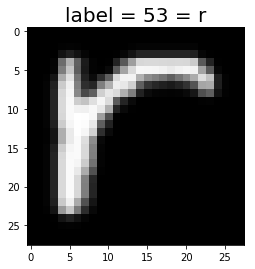

In [5]:
print(raw_train_X.shape, raw_train_y.shape, raw_test_X.shape, raw_test_y.shape)

i = random.randint(0, raw_train_X.shape[0])
fig, ax = plt.subplots()
ax.clear()
ax.imshow(raw_train_X[i].T, cmap='gray')
title = 'label = %d = %s' % (raw_train_y[i], labels[raw_train_y[i]])
ax.set_title(title, fontsize=20)
plt.show()

### Normalize the training and testing input data:

In [6]:
train_X = raw_train_X.astype('float32')
test_X = raw_test_X.astype('float32')

train_X /= 255
test_X /= 255

### Reshape the input data for input to the CNN:

In [7]:
train_X = train_X.reshape(train_X.shape[0], 28, 28, 1)
test_X = test_X.reshape(test_X.shape[0], 28, 28, 1)

### One-hot encode the output (labels) data:

In [8]:
train_y = keras.utils.np_utils.to_categorical(raw_train_y)
test_y = keras.utils.np_utils.to_categorical(raw_test_y)

### Define the CNN model:

In [9]:
model = keras.models.Sequential()
model.add(keras.layers.Conv2D(32,
                kernel_size=(5, 5),
                strides=(2, 2),
                input_shape=(28, 28, 1),
                activation='relu'))
model.add(keras.layers.Conv2D(64,
                kernel_size=(3, 3),
                activation='relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.Dense(categories, activation='softmax'))

### Compile the model:

In [10]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

### Train the model, saving historical data to graph:

In [11]:
t1 = time.time()
fit = model.fit(train_X, train_y, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(test_X, test_y))
t2 = time.time()
print('Elapsed time: %ds' % (t2 - t1))

Train on 697932 samples, validate on 116323 samples
Epoch 1/50
697932/697932 [==============================] - 9s 13us/step - loss: 0.8568 - acc: 0.7453 - val_loss: 0.4536 - val_acc: 0.8411
Epoch 2/50
697932/697932 [==============================] - 8s 12us/step - loss: 0.5036 - acc: 0.8277 - val_loss: 0.4102 - val_acc: 0.8532
Epoch 3/50
697932/697932 [==============================] - 8s 12us/step - loss: 0.4604 - acc: 0.8397 - val_loss: 0.3905 - val_acc: 0.8584
Epoch 4/50
697932/697932 [==============================] - 8s 12us/step - loss: 0.4383 - acc: 0.8455 - val_loss: 0.3811 - val_acc: 0.8601
Epoch 5/50
697932/697932 [==============================] - 8s 12us/step - loss: 0.4234 - acc: 0.8491 - val_loss: 0.3738 - val_acc: 0.8619
Epoch 6/50
697932/697932 [==============================] - 8s 12us/step - loss: 0.4135 - acc: 0.8516 - val_loss: 0.3694 - val_acc: 0.8625
Epoch 7/50
697932/697932 [==============================] - 8s 12us/step - loss: 0.4063 - acc: 0.8541 - val_loss: 

### Evaluate the model using the test data:

In [12]:
results = model.evaluate(test_X, test_y)

116323/116323 [==============================] - 5s 39us/step


### Show the loss and accuracy results:

In [13]:
print('Loss: %.2f%%, Accuracy: %.2f%%' % (results[0]*100, results[1]*100))

Loss: 34.26%, Accuracy: 87.22%


### Graph the model's loss and accuracy:

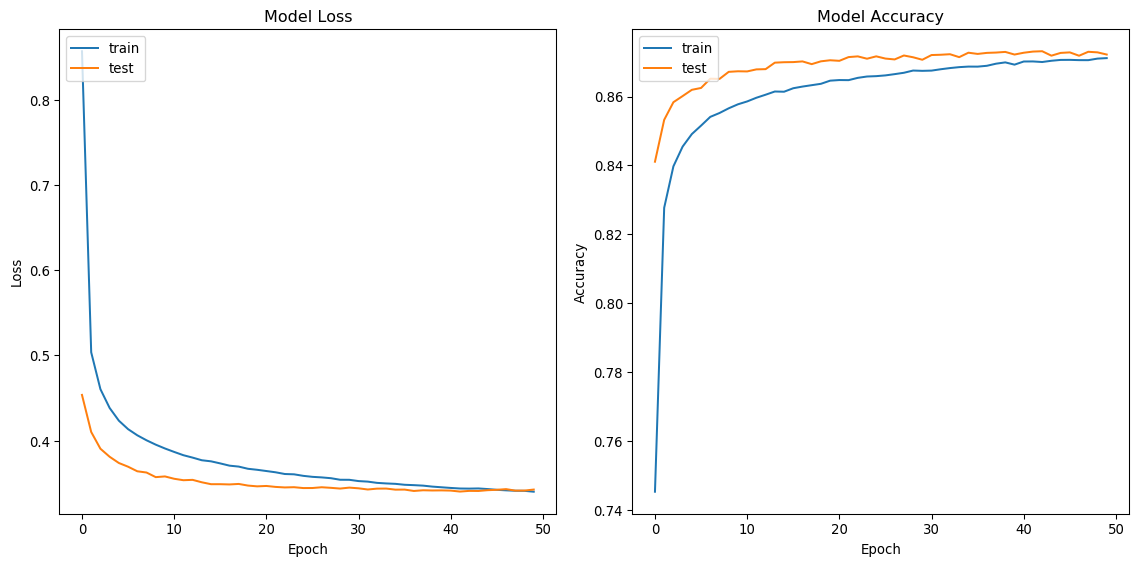

In [14]:
plt.figure(figsize=(12, 6), dpi=96)
plt.subplot(1, 2, 1)
plt.plot(fit.history['loss'])
plt.plot(fit.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'test'], loc='upper left')
plt.subplot(1, 2, 2)
plt.plot(fit.history['acc'])
plt.plot(fit.history['val_acc'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'], loc='upper left')
plt.tight_layout()
plt.show()

### Save the model to disk:

In [15]:
model.save(model_path)

### Load the model from disk:

In [16]:
model_new = keras.models.load_model(model_path)
print(model_new.layers)
results_new = model_new.evaluate(test_X, test_y)
print('Loss: %.2f%%, Accuracy: %.2f%%' % (results_new[0]*100, results_new[1]*100))

[<keras.layers.convolutional.Conv2D object at 0x7f71a40d5c88>, <keras.layers.convolutional.Conv2D object at 0x7f71a409f2b0>, <keras.layers.pooling.MaxPooling2D object at 0x7f71a4093c88>, <keras.layers.core.Dropout object at 0x7f71a61f5400>, <keras.layers.core.Flatten object at 0x7f71a405ff60>, <keras.layers.core.Dense object at 0x7f71a405fbe0>, <keras.layers.core.Dropout object at 0x7f717c7c12e8>, <keras.layers.core.Dense object at 0x7f717c7c15f8>]
116323/116323 [==============================] - 5s 40us/step
Loss: 34.26%, Accuracy: 87.22%
